<h2>Post Checks</h2>

We will start by loading the code for running the model/guide pipeline. 

* Based on when the loss was levelling out, I will reduce the epochs to 40

* I will also add a few more variations of args to try out

In [1]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
import numpy as np
from enum import IntEnum
import enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

assert pyro.__version__.startswith('1.7.0')

class GuessResult(IntEnum):
    FalsePositive = 1  #Blue
    FalseNegative = 2  #Red
    TruePositive = 3   #Green
    TrueNegative = 4   #Black
    
def getGuessColor(guessResult):
    if guessResult == GuessResult.FalsePositive:
        return 'blue'
    if guessResult == GuessResult.FalseNegative:
        return 'red'
    if guessResult == GuessResult.TruePositive:
        return 'green'
    if guessResult == GuessResult.TrueNegative:
        return 'black'
    print("Error! Did not recognize guess result!")
    return 'yellow'

def getLabel(guessResult):
    if guessResult == GuessResult.FalsePositive:
        return "FalsePositive"
    if guessResult == GuessResult.FalseNegative:
        return "FalseNegative"
    if guessResult == GuessResult.TruePositive:
        return "TruePositive"
    if guessResult == GuessResult.TrueNegative:
        return "TrueNegative"
    print("Error! Did not recognize guess result for label!")
    return 'yellowPositive'

class MovementType(enum.Enum):
    Sinusoidal = 1
    Linear2D = 2
    Linear3D = 3

class Args:
    def __init__(self):
        self.args = self.get_default_args()

    def get_high_noise_args(self):
        self.num_frames = 5
        self.max_num_objects = 3
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 1.0
        self.emission_noise_scale = 0.5 
        assert self.max_num_objects >= self.expected_num_objects
        return self         
        
    def get_low_sensor_quality_args(self):
        self.num_frames = 5
        self.max_num_objects = 3
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 0.5
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self          
        
    def get_equal_spurious_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 2.
        self.expected_num_spurious = 2
        self.emission_prob = 1.0
        self.emission_noise_scale = 0.1
        assert self.max_num_objects >= self.expected_num_objects
        return self         
        
    def get_default_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1
        self.emission_prob = 0.8
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self 

    def get_ideal_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 0
        self.emission_prob = 1.0
        self.emission_noise_scale = 0.
        assert self.max_num_objects >= self.expected_num_objects
        return self    

    def get_prior_predictive_checks_args(self):
        self.num_frames = 5
        self.expected_num_objects = int(dist.Uniform(1, 5).sample())
        self.expected_num_spurious = float(int(dist.Uniform(1,3).sample()))
        self.max_num_objects = int(self.expected_num_objects + self.expected_num_spurious)
        self.emission_prob = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 3.)/4.))) #aiming for between [0.5,1.0]
        self.emission_noise_scale = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 2.)/4.))) #aiming for between [0.0,0.5]
        assert self.max_num_objects >= self.expected_num_objects
        print("Predictive check args. Num objects: ", self.expected_num_objects, " Num spurious: ", self.expected_num_spurious)
        print("Emission prob: ", self.emission_prob, " Noise scale: ", self.emission_noise_scale)
        return self


class DataGenerator:
    def __init__(self, movementType):
        print("Initializing DataGenerator with movement type ", movementType)
        self.movementType = movementType
        if self.movementType == MovementType.Sinusoidal:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear2D:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear3D:
            self.numDimensions = 3
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

    def get_dynamics(self, num_frames):
        if self.movementType == MovementType.Sinusoidal:
            time = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([time.cos(), time.sin()], -1)
        elif self.movementType == MovementType.Linear2D:
            x = torch.arange(float(num_frames)) / 4
            y = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([x, y], -1)
        elif self.movementType == MovementType.Linear3D:
            x = torch.arange(float(num_frames)) / 4
            y = torch.arange(float(num_frames)) / 4
            z = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([x, y, z], -1)
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

        return dynamics

    def generate_data(self, args):
        # Object model.
        num_objects = int(round(args.expected_num_objects))  
        print("Num frames: ", args.num_frames, " with num objects: ", num_objects)
        states = dist.Normal(0., 1.).sample((num_objects, self.numDimensions))

        # Detection model.
        emitted = dist.Bernoulli(args.emission_prob).sample((args.num_frames, num_objects))
        if args.expected_num_spurious == 0:
            num_spurious = torch.zeros((args.num_frames,1))
        else:
            num_spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,))
            print("Num spurious shape: ", num_spurious.shape)
        max_num_detections = int((num_spurious + emitted.sum(-1)).max())
        observations = torch.zeros(args.num_frames, max_num_detections, 2) # position+confidence
        positions = self.get_dynamics(args.num_frames).mm(states.t())

        noisy_positions = dist.Normal(positions, args.emission_noise_scale).sample()
        for t in range(args.num_frames):
            j = 0
            for i, e in enumerate(emitted[t]):
                if e:
                    observations[t, j, 0] = noisy_positions[t, i]
                    observations[t, j, 1] = 1
                    j += 1
            n = int(num_spurious[t])
            if n:
                observations[t, j:j+n, 0] = dist.Normal(0., 1.).sample((n,))
                observations[t, j:j+n, 1] = 1

        return states, positions, observations, self.numDimensions


class TargetProbabilisticModel:
    def __init__(self, args, dynamics):
        self.args = args
        self.dynamics = dynamics

    def model(self, args, observations):
        with pyro.plate("objects", self.args.max_num_objects):
            exists = pyro.sample("exists",
                                dist.Bernoulli(self.args.expected_num_objects / self.args.max_num_objects))
            with poutine.mask(mask=exists.bool()):
                states = pyro.sample("states", dist.Normal(0., 1.).expand([self.args.num_dimensions]).to_event(1))
                positions = self.dynamics.mm(states.t())
        with pyro.plate("detections", observations.shape[1]):
            with pyro.plate("time", self.args.num_frames):
                # The combinatorial part of the log prob is approximated to allow independence.
                is_observed = (observations[..., -1] > 0)
                with poutine.mask(mask=is_observed):
                    assign = pyro.sample("assign",
                                        dist.Categorical(torch.ones(self.args.max_num_objects + 1)))
                is_spurious = (assign == self.args.max_num_objects)
                is_real = is_observed & ~is_spurious
                num_observed = is_observed.float().sum(-1, True)

                bernoulliRealProbs = self.args.expected_num_objects / num_observed
                bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
                pyro.sample("is_real",
                            dist.Bernoulli(bernoulliRealProbs),
                            obs=is_real.float())

                bernoulliSpuriousProbs = self.args.expected_num_spurious / num_observed
                bernoulliSpuriousProbs = np.clip(bernoulliSpuriousProbs, 0., 1.)
                pyro.sample("is_spurious",
                            dist.Bernoulli(bernoulliSpuriousProbs),
                            obs=is_spurious.float())

                # The remaining continuous part is exact.
                observed_positions = observations[..., 0]
                with poutine.mask(mask=is_real):
                    bogus_position = positions.new_zeros(self.args.num_frames, 1)
                    augmented_positions = torch.cat([positions, bogus_position], -1)
                    predicted_positions = gather(augmented_positions, assign, -1)
                    pyro.sample("real_observations",
                                dist.Normal(predicted_positions, self.args.emission_noise_scale),
                                obs=observed_positions)
                with poutine.mask(mask=is_spurious):
                    pyro.sample("spurious_observations", dist.Normal(0., 1.),
                                obs=observed_positions)

    def guide(self, args, observations):
        # Initialize states randomly from the prior.
        states_loc = pyro.param("states_loc", lambda: torch.randn(int(self.args.max_num_objects), int(self.args.num_dimensions)))
        states_scale = pyro.param("states_scale",
                                lambda: torch.ones(states_loc.shape) * self.args.emission_noise_scale,
                                constraint=constraints.positive)
        positions = self.dynamics.mm(states_loc.t())

        # Solve soft assignment problem.
        real_dist = dist.Normal(positions.unsqueeze(-2), self.args.emission_noise_scale)
        spurious_dist = dist.Normal(0., 1.)
        is_observed = (observations[..., -1] > 0)
        observed_positions = observations[..., 0].unsqueeze(-1)
        assign_logits_calc = 0 if (self.args.expected_num_spurious == 0) else (self.args.expected_num_objects * self.args.emission_prob /
                                self.args.expected_num_spurious)
        exist_logits_calc = 0 if (self.args.expected_num_spurious == 0) else (self.args.max_num_objects / self.args.expected_num_objects)
        
        if self.args.expected_num_spurious == 0:
                    assign_logits = real_dist.log_prob(observed_positions)
        else:
            assign_logits = (real_dist.log_prob(observed_positions) -
                            spurious_dist.log_prob(observed_positions) +
                            math.log(assign_logits_calc))
        assign_logits[~is_observed] = -float('inf')
        if self.args.expected_num_spurious == 0:
            exists_logits = torch.empty(self.args.max_num_objects).fill_(
                1)            
        else:
            exists_logits = torch.empty(self.args.max_num_objects).fill_(
                math.log(exist_logits_calc))
        assignment = MarginalAssignmentPersistent(exists_logits, assign_logits)

        with pyro.plate("objects", self.args.max_num_objects):
            exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
            with poutine.mask(mask=exists.bool()):
                pyro.sample("states", dist.Normal(states_loc, states_scale).to_event(1))
        with pyro.plate("detections", observations.shape[1]):
            with poutine.mask(mask=is_observed):
                with pyro.plate("time", self.args.num_frames):
                    assign = pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

        return assignment

    def train(self, true_states, true_positions, observations, visualize = False, visualizeJustAfter=True):
        pyro.set_rng_seed(0)
        true_num_objects = len(true_states)
        max_num_detections = observations.shape[1]
        print("generated {:d} detections from {:d} objects".format(
            (observations[..., -1] > 0).long().sum(), true_num_objects))

        pyro.set_rng_seed(1)
        pyro.clear_param_store()
        if visualize:
            self.plot_solution( observations, true_positions, '(before training)')

        infer = SVI(self.model, self.guide, Adam({"lr": 0.01}), TraceEnum_ELBO(max_plate_nesting=2))
        losses = []
        for epoch in range(41):
            loss = infer.step(self.args, observations)
            if epoch % 10 == 0:
                print("epoch {: >4d} loss = {}".format(epoch, loss))
                losses.append(loss)
        if visualize or visualizeJustAfter:
            pyplot.plot(losses)
            self.plot_solution(observations, true_positions, '(after training)')
        return self.args, losses[-1]

    def get_predicted_positions(self):
        states_loc = pyro.param("states_loc")
        return self.dynamics.mm(states_loc.t())

    def plot_solution(self, observations, true_positions, dangerZone=False,  dangerZoneColor='yellow', dangerPosition=(0,0), dangerSize=0, message=''):
        print("Plotting solution with color: ", dangerZoneColor)
        assignment = self.guide(self.args, observations)
        states_loc = pyro.param("states_loc")
        positions = self.dynamics.mm(states_loc.t())
        pyplot.figure(figsize=(12,6)).patch.set_color('white')
        pyplot.plot(true_positions.numpy(), 'k--')
        is_observed = (observations[..., -1] > 0)
        pos = observations[..., 0]
        time = torch.arange(float(self.args.num_frames)).unsqueeze(-1).expand_as(pos)
        pyplot.scatter(time[is_observed].view(-1).numpy(),
                    pos[is_observed].view(-1).numpy(), color='k', marker='+',
                    label='observation')
        for i in range(self.args.max_num_objects):
            p_exist = assignment.exists_dist.probs[i].item()
            position = positions[:, i].detach().numpy()
            pyplot.plot(position, alpha=p_exist, color='C0')
            
        if dangerZone:
            rectangle = plt.Rectangle(dangerPosition, dangerSize, dangerSize, fc=dangerZoneColor,ec="black")
            plt.gca().add_patch(rectangle)
            
        pyplot.title('Truth, observations, and predicted tracks ' + message)
        pyplot.plot([], 'k--', label='truth')
        pyplot.plot([], color='C0', label='prediction')
        pyplot.legend(loc='best')
        pyplot.xlabel('time step')
        pyplot.ylabel('position')
        pyplot.tight_layout()
        pyplot.show()
        
 
        
class Results:
    def __init__(self):
        self.expectedObjects = []
        self.expectedSpurious = []
        self.emissionProb = []
        self.emissionNoise = []
        self.losses = []
        
    def addResult(self, args, loss):
        self.expectedObjects.append(args.expected_num_objects)
        self.expectedSpurious.append(args.expected_num_spurious)
        self.emissionProb.append(args.emission_prob)
        self.emissionNoise.append(args.emission_noise_scale)
        self.losses.append(loss)
    
    def plotResults(self):
        plt.title("Emission Noise")
        plt.plot(self.emissionNoise, self.losses)
        plt.show()
        
        plt.title("Emission probability")
        plt.plot(self.emissionProb, self.losses)
        plt.show()
        
        plt.title("Expected Spurious")
        plt.plot(self.expectedSpurious, self.losses)
        plt.show()
        
        
class PipelineManager:
    def __init__(self):
        self.argManager = Args()
        self.dataGenerator = DataGenerator(MovementType.Linear2D) 
        self.results = Results()

    def trainAndPredict(self, args):
        dynamics = self.dataGenerator.get_dynamics(args.num_frames)

        true_states, true_positions, observations, num_dimensions = self.dataGenerator.generate_data(args)
        args.num_dimensions = int(num_dimensions)

        targetProbabilisticModel = TargetProbabilisticModel(args, dynamics)
        args, loss = targetProbabilisticModel.train(true_states, true_positions, observations, True)
        self.results.addResult(args, loss)
        #targetProbabilisticModel.plot_solution(observations, true_positions)
        
    def runHighNoise(self):
        args = self.argManager.get_high_noise_args()
        self.trainAndPredict(args)
        
    def runLowSensorQuality(self):
        args = self.argManager.get_low_sensor_quality_args()
        self.trainAndPredict(args)
        
    def runEqualSpurious(self):
        args = self.argManager.get_equal_spurious_args()
        self.trainAndPredict(args)

    def runDefault(self):
        args = self.argManager.get_default_args()
        self.trainAndPredict(args)
        
    def runIdeal(self):
        args = self.argManager.get_ideal_args()
        self.trainAndPredict(args)
        
    def runAll(self):
        print("High Noise Scenario")
        self.runHighNoise()
        print("Low Sensor Quality Scenario")
        self.runLowSensorQuality()
        print("Equal Spurious and Real Objects Scenario")
        self.runEqualSpurious()
        print("Default Arguments Scenario")
        self.runDefault()
        #print("Ideal Scenario")
        #self.runIdeal()
        
    def plotResults(self):
        self.results.plotResults()



Initializing DataGenerator with movement type  MovementType.Linear2D
High Noise Scenario
Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects


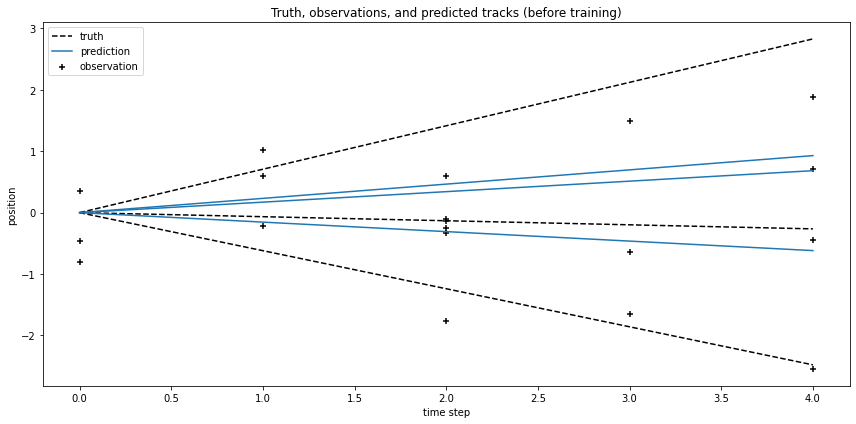

epoch    0 loss = 266.11224365234375
epoch   10 loss = 262.7938232421875
epoch   20 loss = 260.087646484375
epoch   30 loss = 263.3831481933594
epoch   40 loss = 262.95880126953125


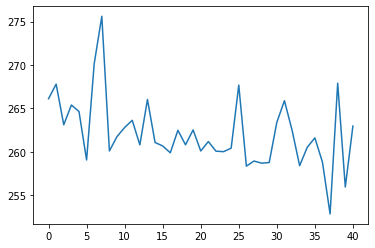

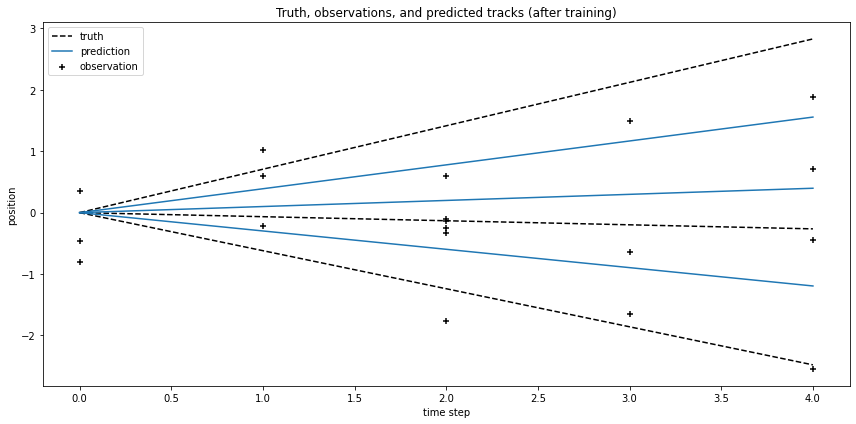

Low Sensor Quality Scenario
Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 12 detections from 3 objects


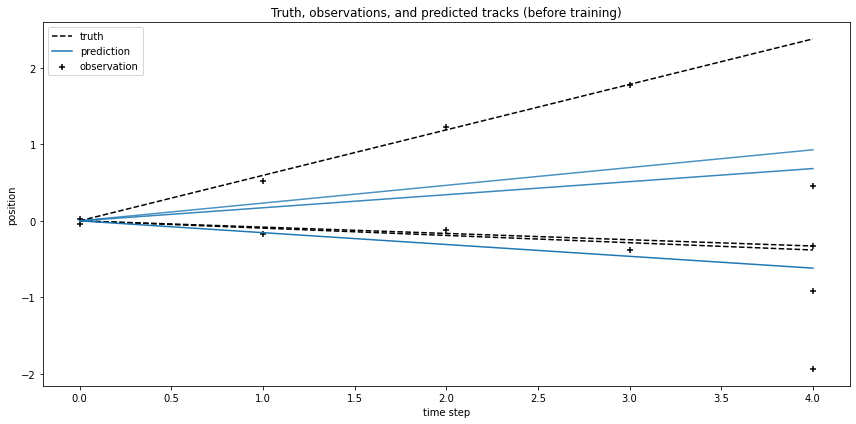

epoch    0 loss = 241.0337677001953
epoch   10 loss = 227.3340606689453
epoch   20 loss = 224.3678436279297
epoch   30 loss = 219.99977111816406
epoch   40 loss = 218.5933380126953


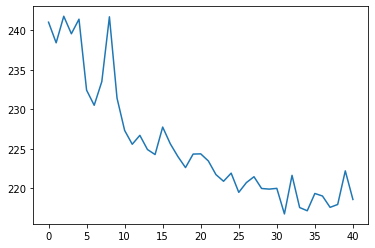

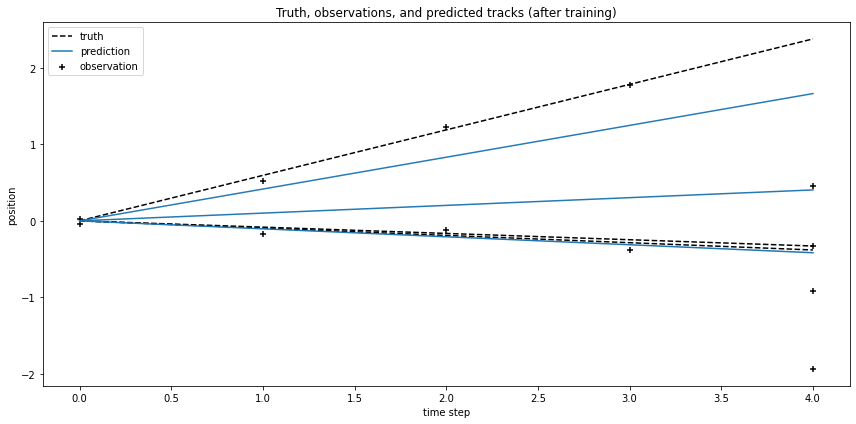

Equal Spurious and Real Objects Scenario
Num frames:  5  with num objects:  2
Num spurious shape:  torch.Size([5])
generated 20 detections from 2 objects


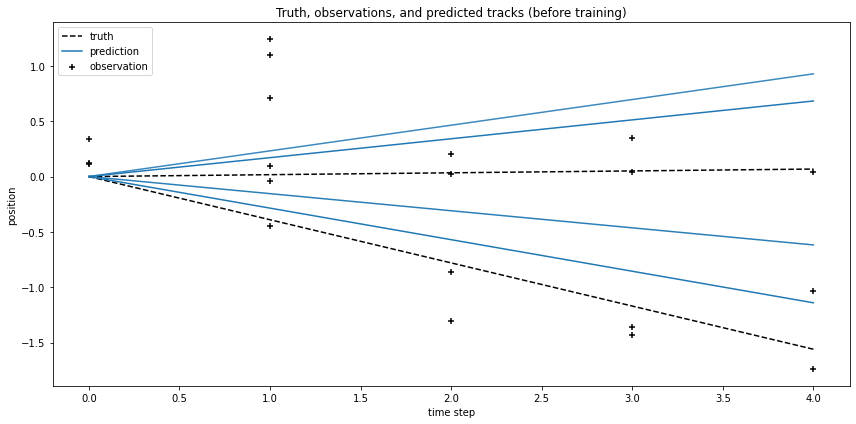

epoch    0 loss = 111.21180725097656
epoch   10 loss = 109.0929183959961
epoch   20 loss = 105.29283905029297
epoch   30 loss = 101.33145141601562
epoch   40 loss = 103.41041564941406


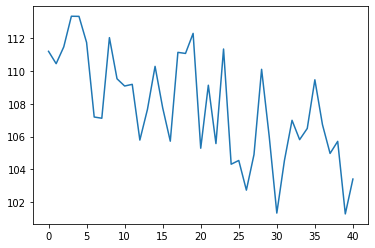

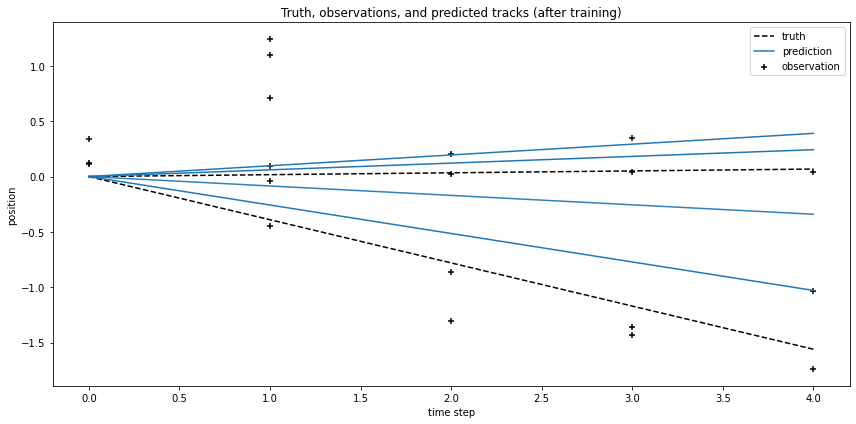

Default Arguments Scenario
Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 20 detections from 3 objects


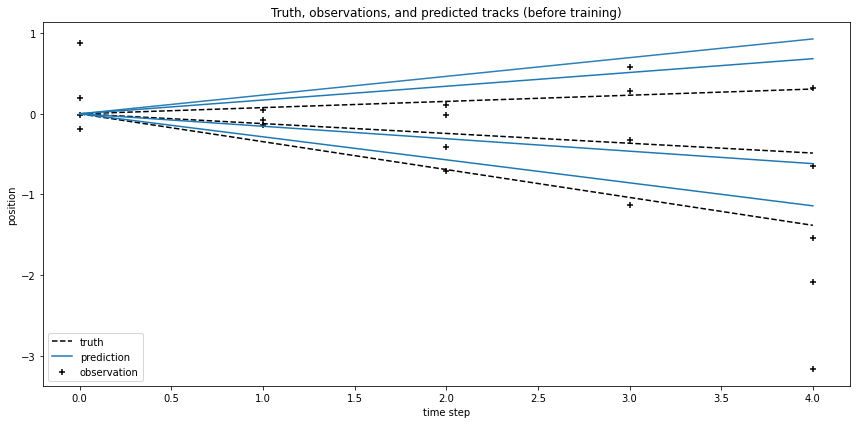

epoch    0 loss = 135.04373168945312
epoch   10 loss = 120.46704864501953
epoch   20 loss = 114.1872787475586
epoch   30 loss = 107.2333755493164
epoch   40 loss = 113.8332748413086


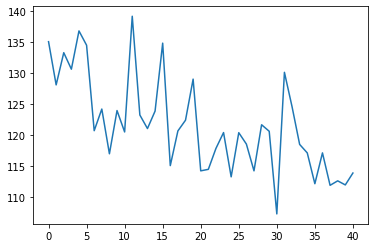

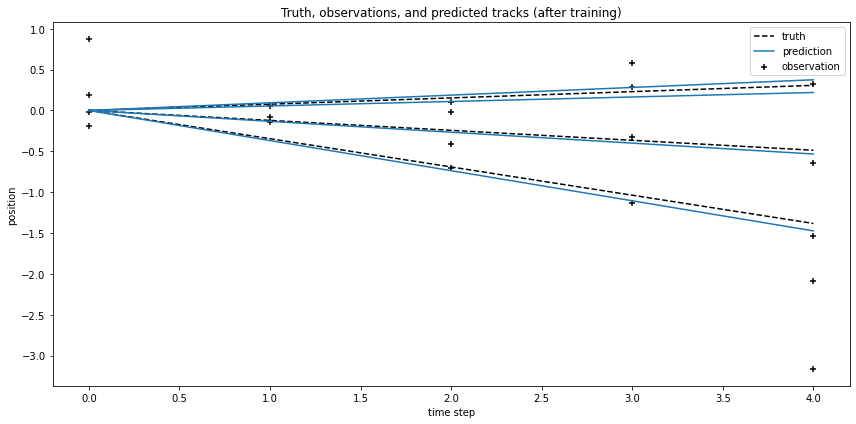

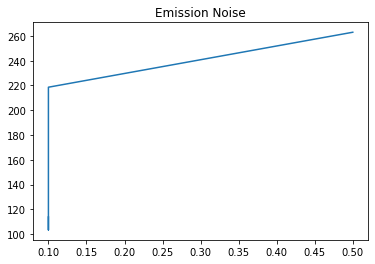

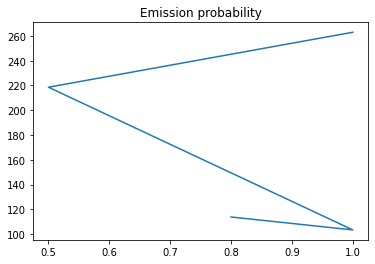

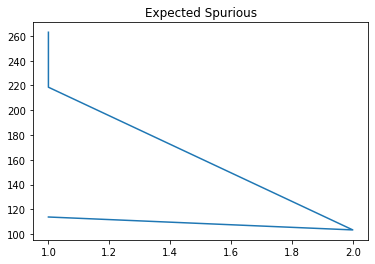

In [8]:
pm = PipelineManager()
pm.runAll()
pm.plotResults()

<h2>Results Comparison</h2>

We can see that with these results any one area of weakness makes the model not work very well. However, the default arguments where the scenario isn't too weak in any one area results in a well working model. 

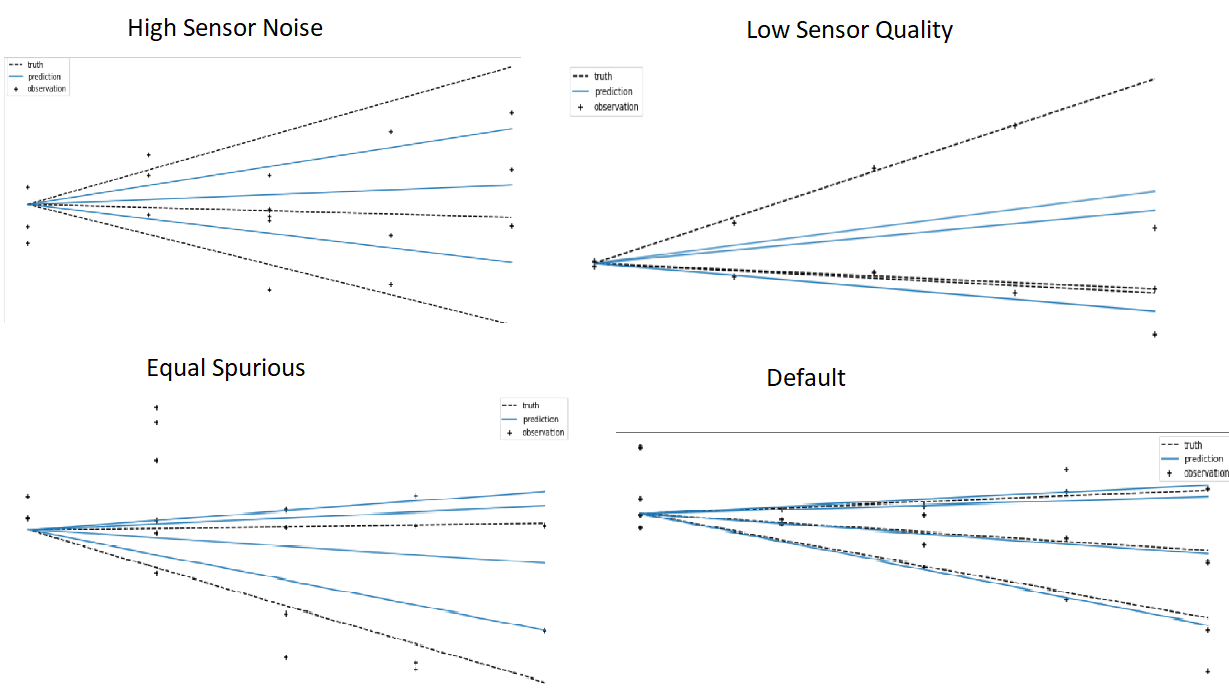

<h2>Reaction and Result</h2>
Now that we have a pipeline and have done post predictive checks, we can run to prompt a result. For instance, we have a **DANGER ZONE** that we don't want our target to go into. So, we'll simulate predicting the location, and see how often we're able to get it right if the target crosses the **DANGER ZONE**.

In [2]:
class RealScenarioManager:
    def __init__(self):
        self.argManager = Args()
        self.dataGenerator = DataGenerator(MovementType.Linear2D) 
        self.dangerZoneCenter = (3.0, 0.5)
        self.dangerZoneSizes = [0.1, 0.5, 1.0]
        self.results = []
        self.results1 = []
        self.results2 = []
        self.results3 = []
        self.labels = []
        self.labels1 = []
        self.labels2 = []
        self.labels3 = []

    def runScenario(self):
        args = self.argManager.get_default_args()
        dynamics = self.dataGenerator.get_dynamics(args.num_frames)

        for i in range(10):
            true_states, true_positions, observations, num_dimensions = self.dataGenerator.generate_data(args)
            args.num_dimensions = int(num_dimensions)

            targetProbabilisticModel = TargetProbabilisticModel(args, dynamics)
            args, loss = targetProbabilisticModel.train(true_states, true_positions, observations, False)
            predictedPositions = targetProbabilisticModel.get_predicted_positions()
            print("Positions!!!")
            print(predictedPositions)
            
            for size in self.dangerZoneSizes:
                result = self.checkIfInDangerZone(predictedPositions, true_positions, self.dangerZoneCenter, size, args)
                floatResult = (int(result))
                guessColor = getGuessColor(result)
                print("Result: ", result, " for size: ", size, " with guess color: ", guessColor)
                targetProbabilisticModel.plot_solution(observations, true_positions, True, guessColor, self.dangerZoneCenter, size)
                self.results.append(floatResult)
                self.labels.append(getLabel(result))
                if size == self.dangerZoneSizes[0]:
                    self.results1.append(floatResult)
                    self.labels1.append(getLabel(result))
                elif size == self.dangerZoneSizes[1]:
                    self.results2.append(floatResult)
                    self.labels2.append(getLabel(result))
                elif size == self.dangerZoneSizes[2]:
                    self.results3.append(floatResult)
                    self.labels3.append(getLabel(result))
                else:
                    print("Something went wrong, don't recognize the size")
        
        pieLabels = ["FalsePositive", "FalseNegative", "TruePositive", "TrueNegative"]
        resultsBreakdown, pl = self.getContributionCount(self.results, pieLabels)
        plt.pie(resultsBreakdown, labels=pl)
        plt.title("Combined results (0.1,0.5,1.0)")
        plt.show()
        
        resultsBreakdown1, pl = self.getContributionCount(self.results1, pieLabels)
        plt.pie(resultsBreakdown1, labels=pl)
        plt.title("0.1 Size threshold")
        plt.show()
        
        resultsBreakdown2, pl = self.getContributionCount(self.results2, pieLabels)
        plt.pie(resultsBreakdown2, labels=pl)
        plt.title("0.5 Size threshold")
        plt.show()
        
        resultsBreakdown3, pl = self.getContributionCount(self.results3, pieLabels)
        plt.pie(resultsBreakdown3, labels=pl)
        plt.title("1.0 Size threshold")
        plt.show()
        
    def getContributionCount(self, labels, pl):
        labels = np.array(labels)
        print(labels)
        falsePositiveCount = np.count_nonzero(labels == int(GuessResult.FalsePositive))
        falseNegativeCount = np.count_nonzero(labels == int(GuessResult.FalseNegative))
        truePositiveCount = np.count_nonzero(labels == int(GuessResult.TruePositive))
        trueNegativeCount = np.count_nonzero(labels == int(GuessResult.TrueNegative))
        print("FP: ", falsePositiveCount, " FN: ", falseNegativeCount, " TP: ", truePositiveCount, " TN: ", trueNegativeCount)
        
        returnValues = []
        returnLabels = []
        if falsePositiveCount > 0:
            returnValues.append(falsePositiveCount)
            returnLabels.append("FalsePositive")
        if falseNegativeCount > 0:
            returnValues.append(falseNegativeCount)
            returnLabels.append("FalseNegative")
        if truePositiveCount > 0:
            returnValues.append(truePositiveCount)
            returnLabels.append("TruePositive")
        if trueNegativeCount > 0:
            returnValues.append(trueNegativeCount)
            returnLabels.append("TrueNegative")
        return returnValues, returnLabels
        
    def checkIfInDangerZone(self, predictionPositions, truePositions, dangerPosition, dangerSize, args):
        predictionCrosses = False
        truePositionCrosses = False
        
        #we know the first point for all will be 0, so we can get the second point and take the slope
        #ax + by + c = 0
        for i in range((predictionPositions.shape[1])):
            predictionCrosses = predictionCrosses or self.singleCheckDangerZone(i, 0, dangerPosition, dangerSize, args, "prediction positions")
            
        for i in range((truePositions.shape[1])):
            truePositionCrosses = truePositionCrosses or self.singleCheckDangerZone(i, 0, dangerPosition, dangerSize, args, "true positions")
        
        if predictionCrosses and truePositionCrosses:
            print("Found true positive with: ", predictionCrosses, " and ", truePositionCrosses)
            guessResult = GuessResult.TruePositive
        elif predictionCrosses and not truePositionCrosses:
            print("Found false negative with: ", predictionCrosses, " and ", truePositionCrosses)
            guessResult = GuessResult.FalseNegative
        elif not predictionCrosses and truePositionCrosses:
            print("Found true negative with: ", predictionCrosses, " and ", truePositionCrosses)
            guessResult = GuessResult.TrueNegative
        elif not predictionCrosses and not truePositionCrosses:
            print("Found false positive with: ", predictionCrosses, " and ", truePositionCrosses)
            guessResult = GuessResult.FalsePositive
        else:
            print("Error, not recognizing result!")
        return guessResult
    
    def singleCheckDangerZone(self, slope, b, dangerPosition, dangerSize, args, msg):
        slope = float(slope/args.num_frames)
        cornerUpperLeft = (dangerPosition[0], dangerPosition[1] + dangerSize)
        cornerLowerRight = (dangerPosition[0] + dangerSize, dangerPosition[1])
        print("Upper left: ", cornerUpperLeft, " LowerRight: ", cornerLowerRight)
        print("Slope: ", slope)
        
        #check to see if y is within corners at slope
        y1 = slope * cornerUpperLeft[0]
        y2 = slope * cornerLowerRight[0]
        
        print("y1: ", y1, " y2: ", y2)
        if (((y1 <= cornerUpperLeft[1]) and (y1 >= cornerLowerRight[1])) or ((y2 <= cornerUpperLeft[1]) and (y2 >= cornerLowerRight[1]))):
            print("Returning true for: ", msg)
            return True
        else:
            return False
            print("Returning false for: ", msg)


Initializing DataGenerator with movement type  MovementType.Linear2D
Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


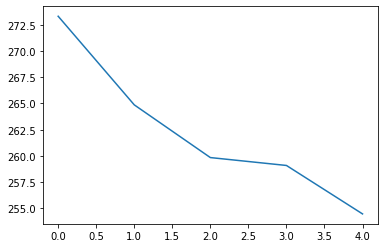

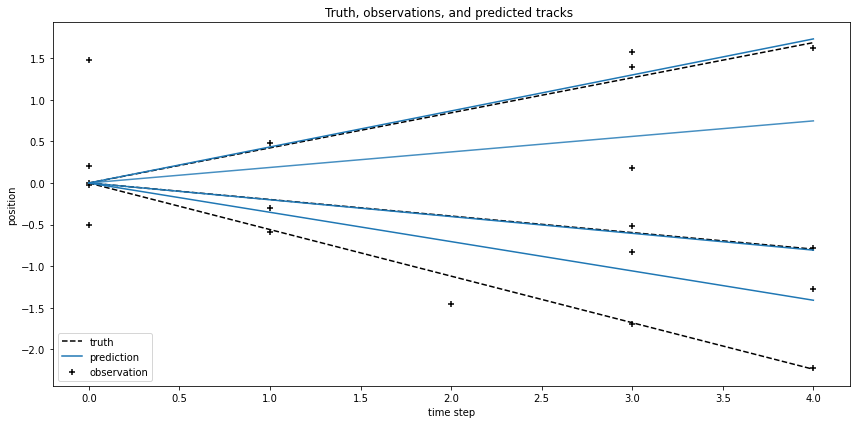

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

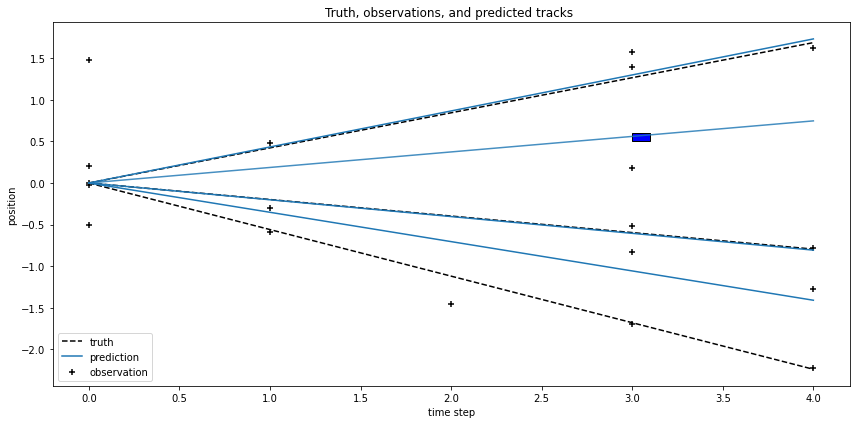

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


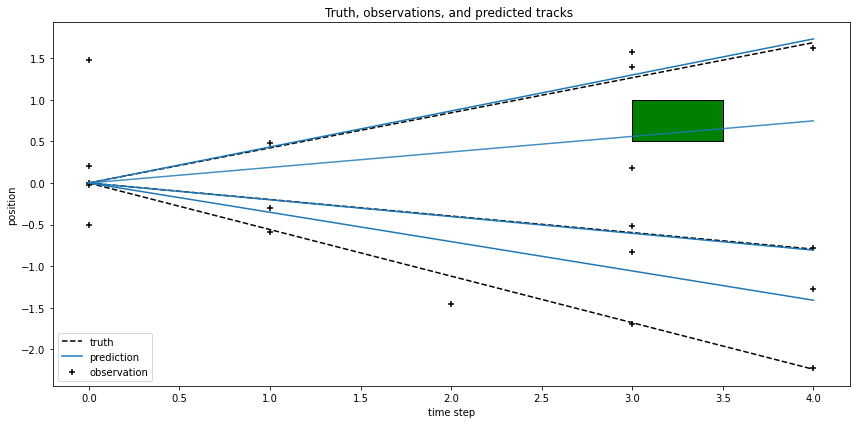

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


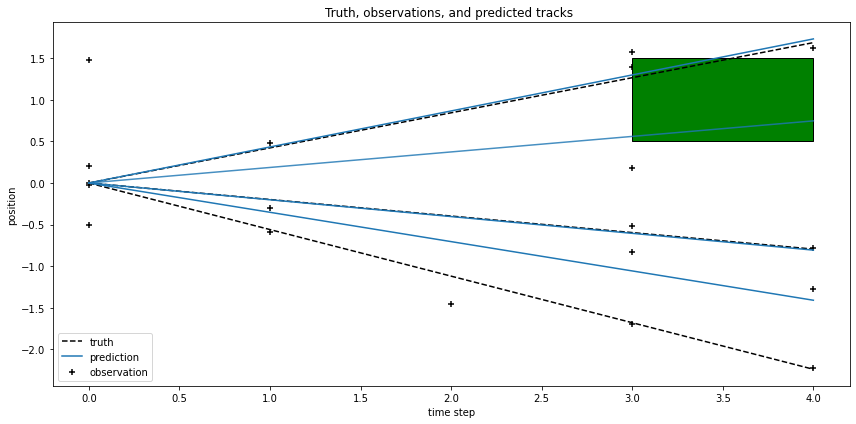

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


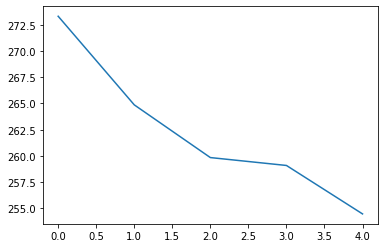

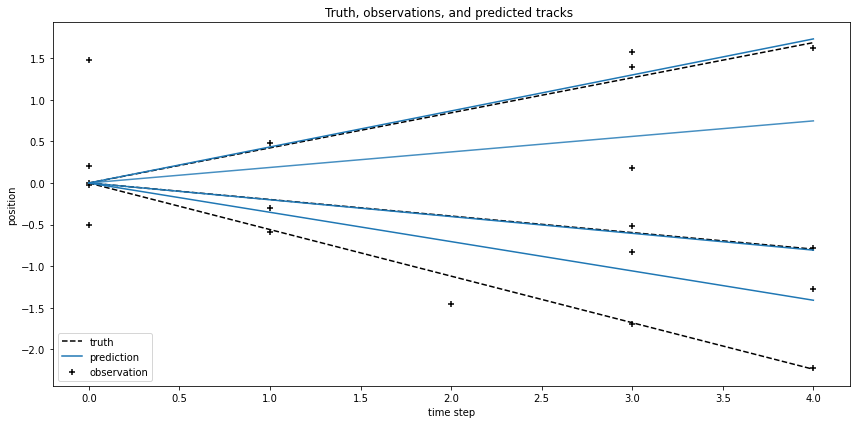

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

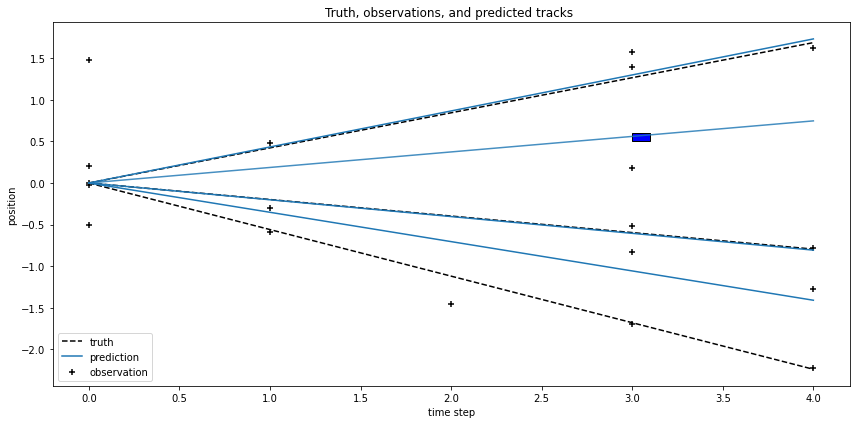

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


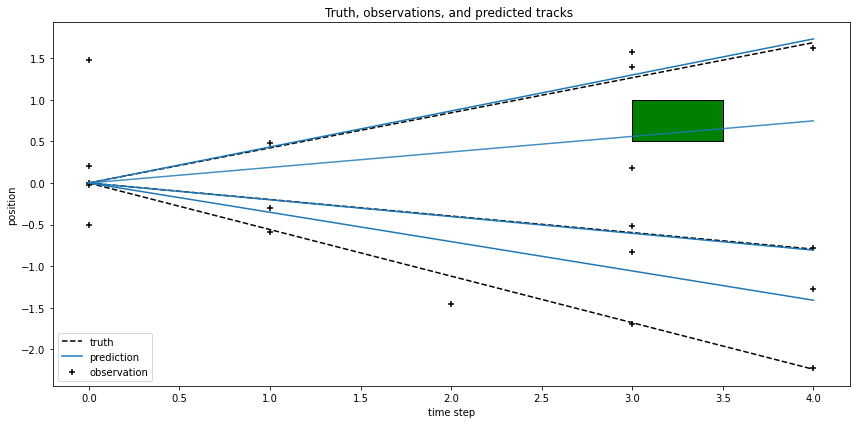

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


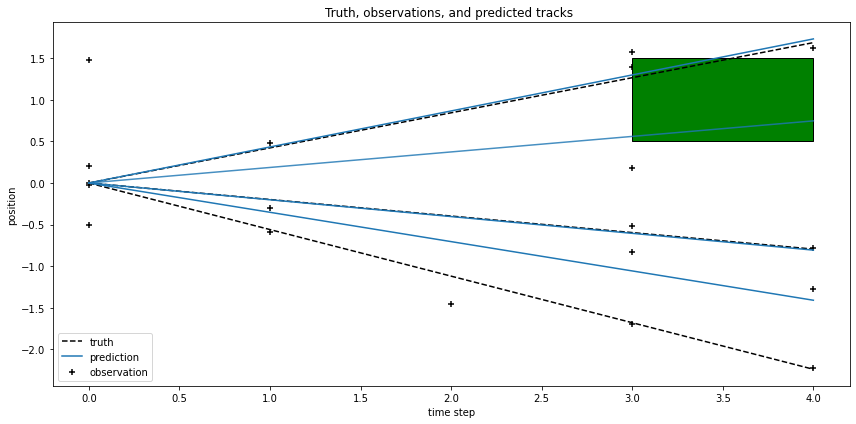

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


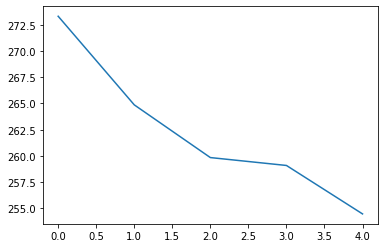

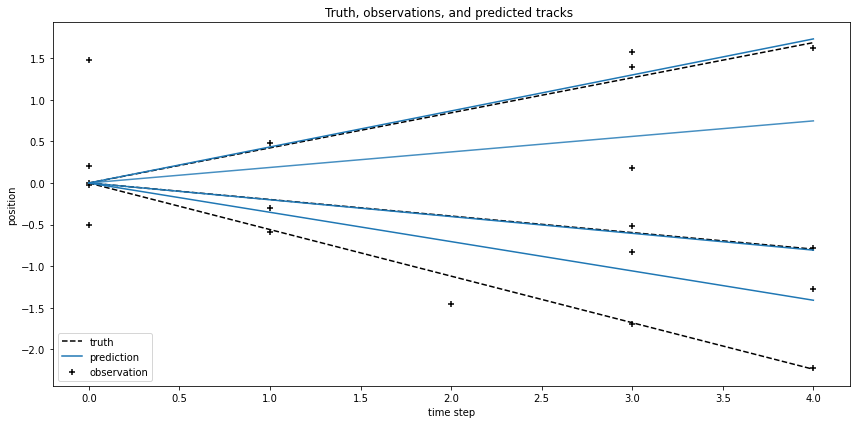

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

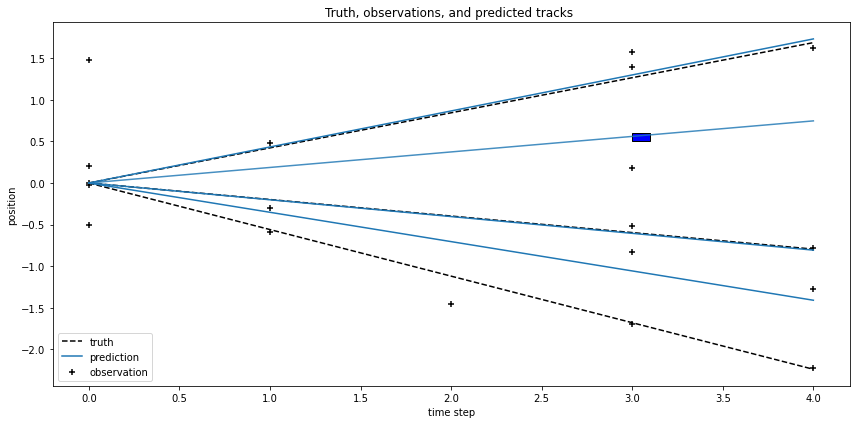

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


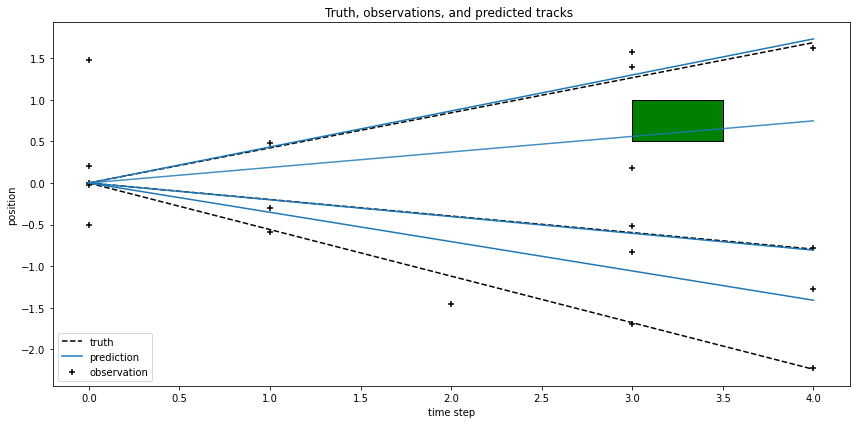

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


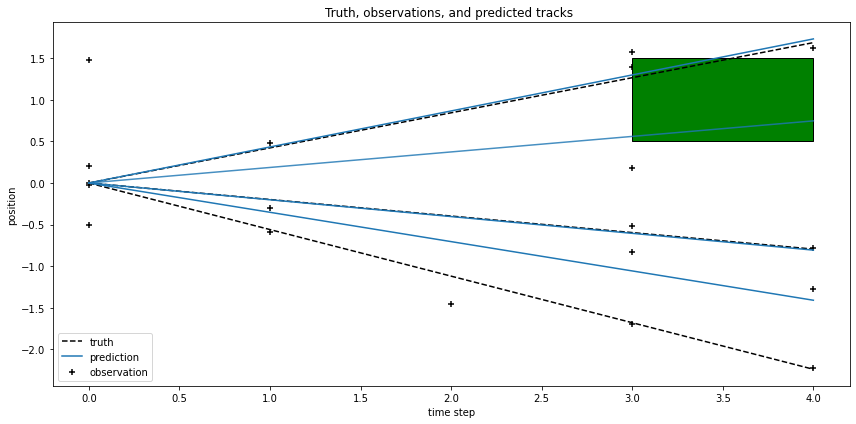

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


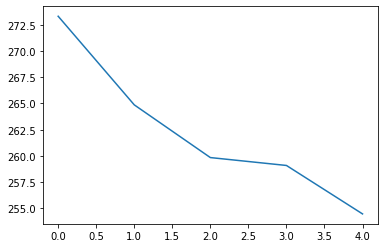

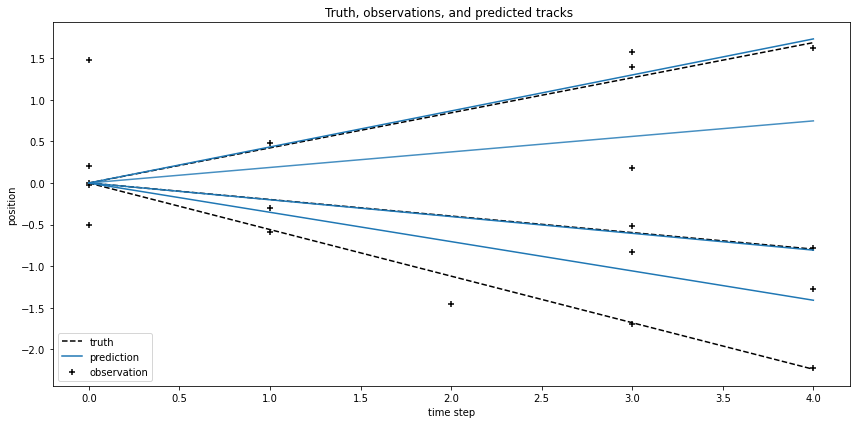

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

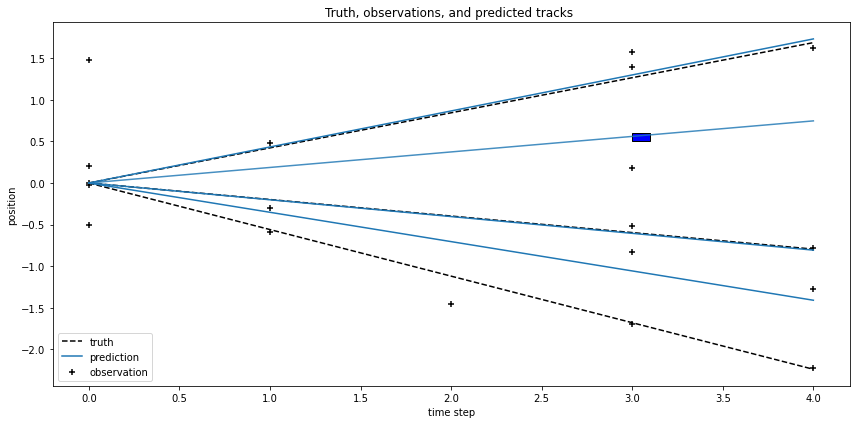

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


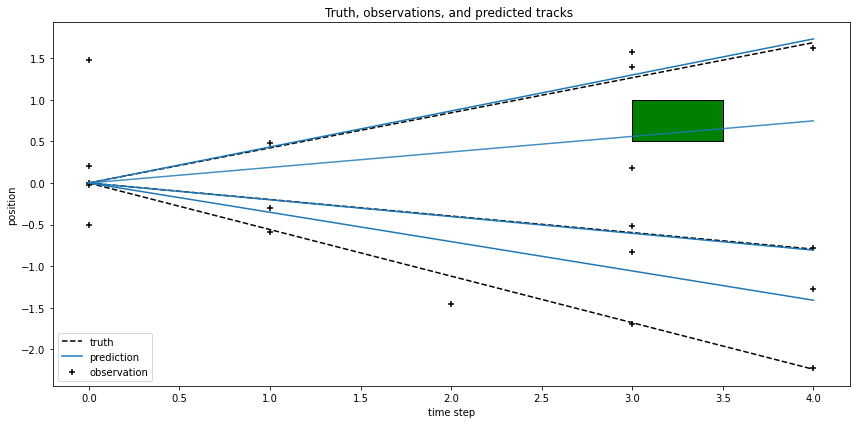

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


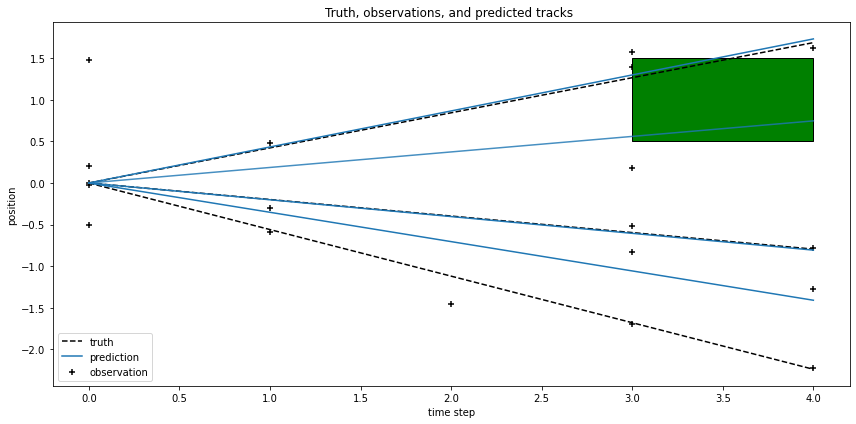

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


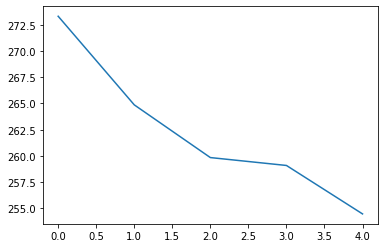

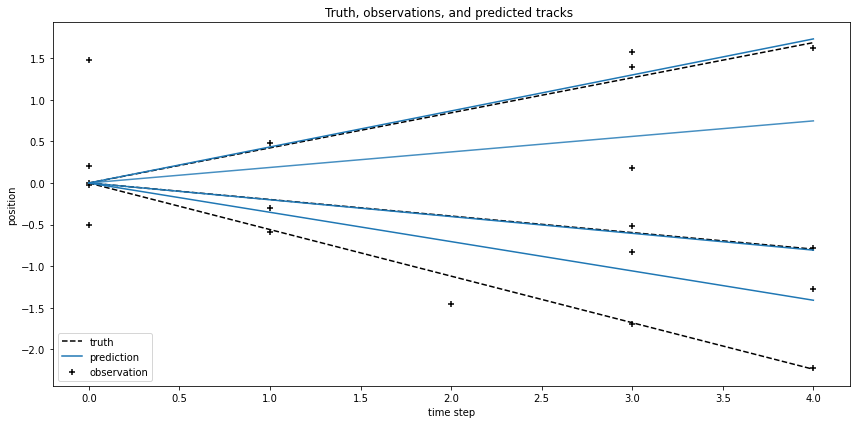

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

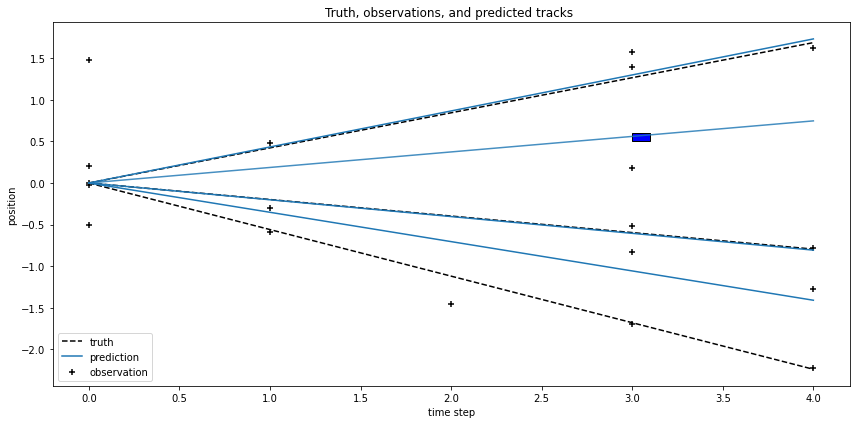

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


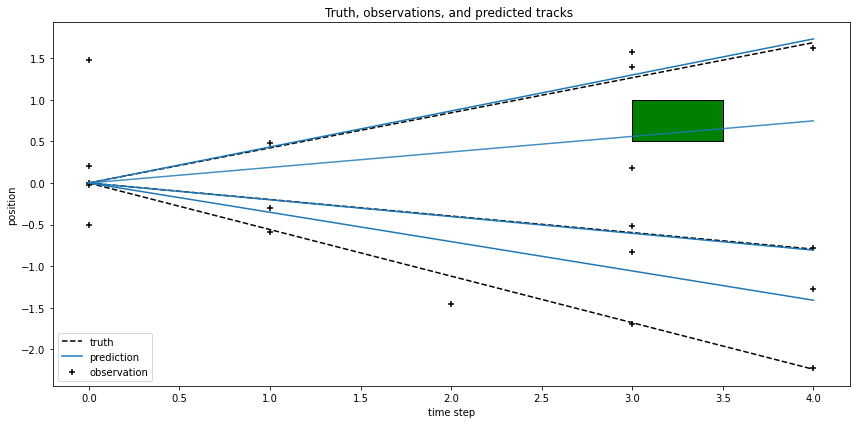

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


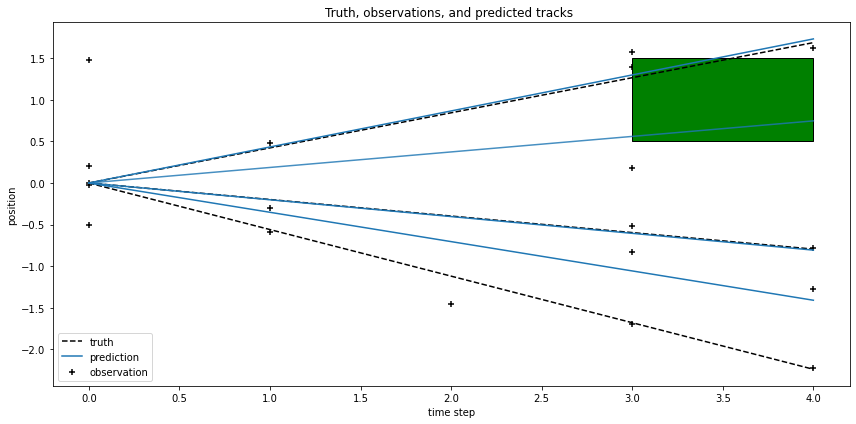

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


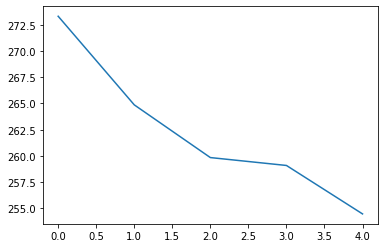

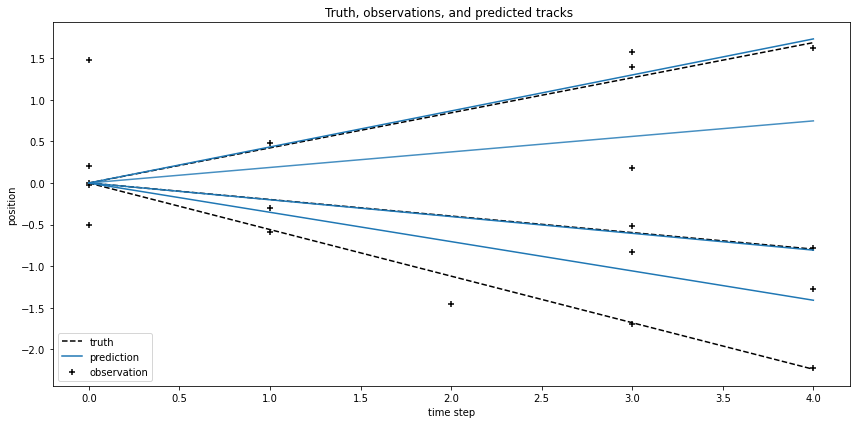

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

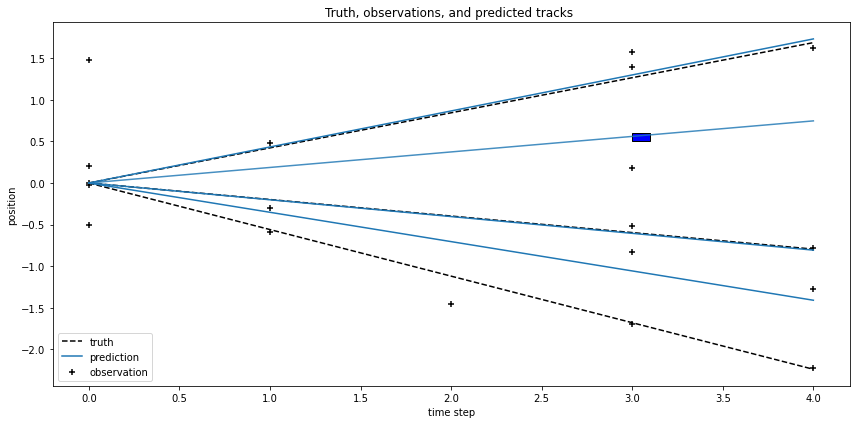

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


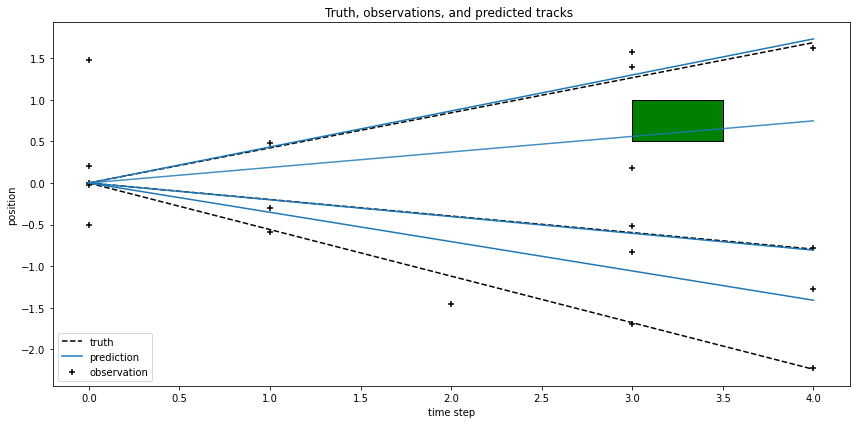

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


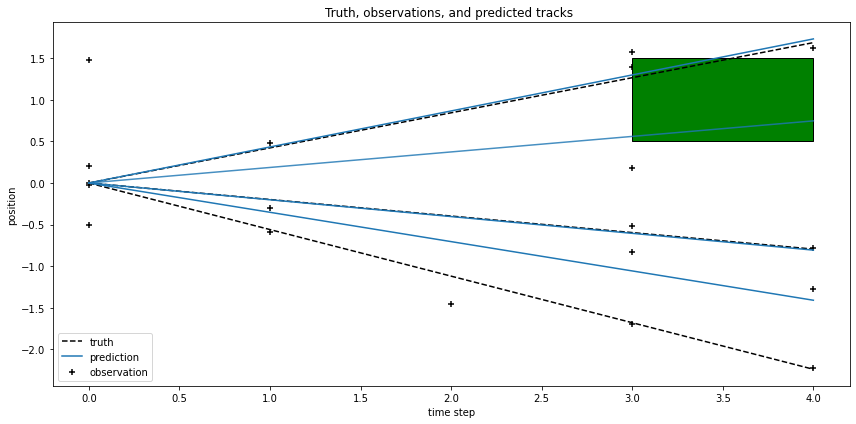

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


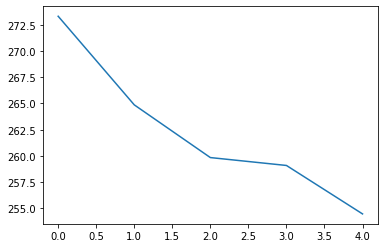

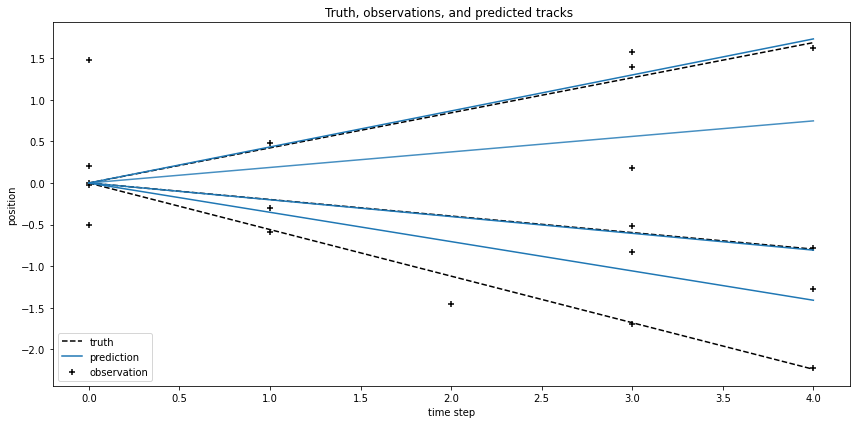

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

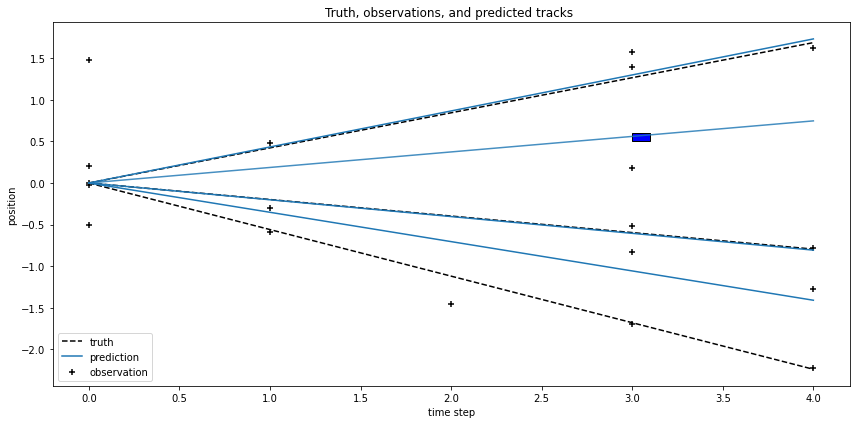

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


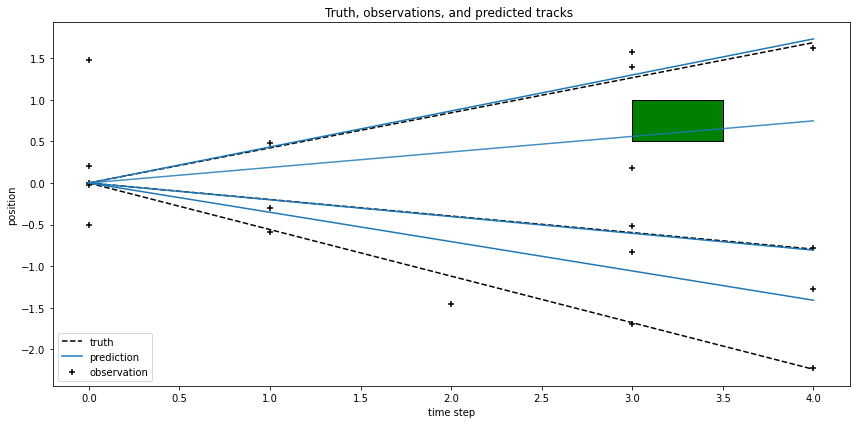

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


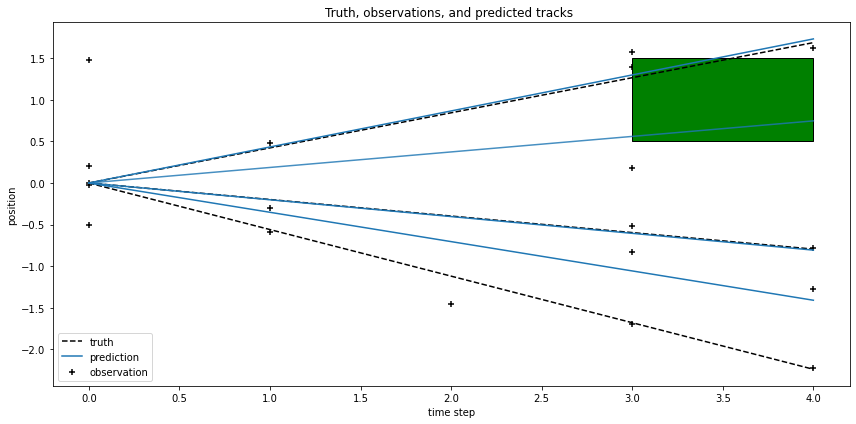

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


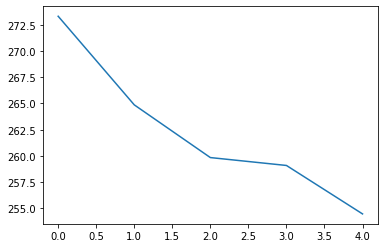

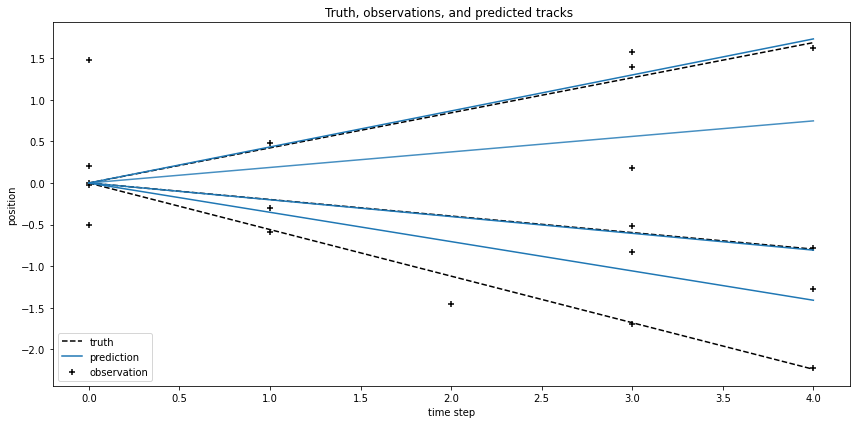

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

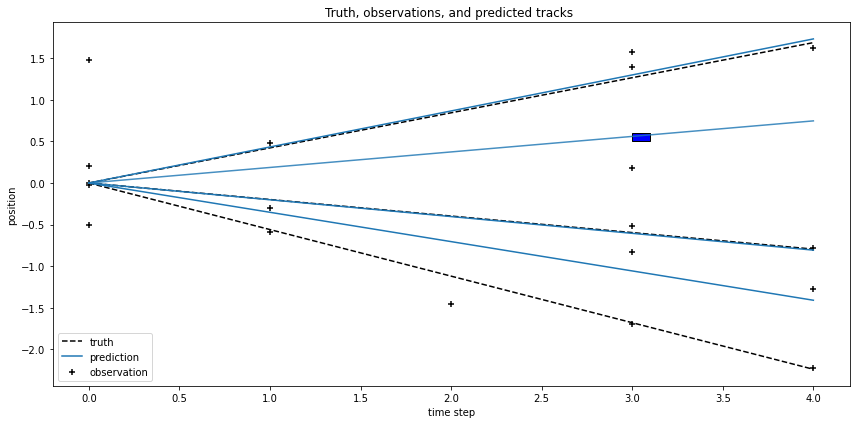

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


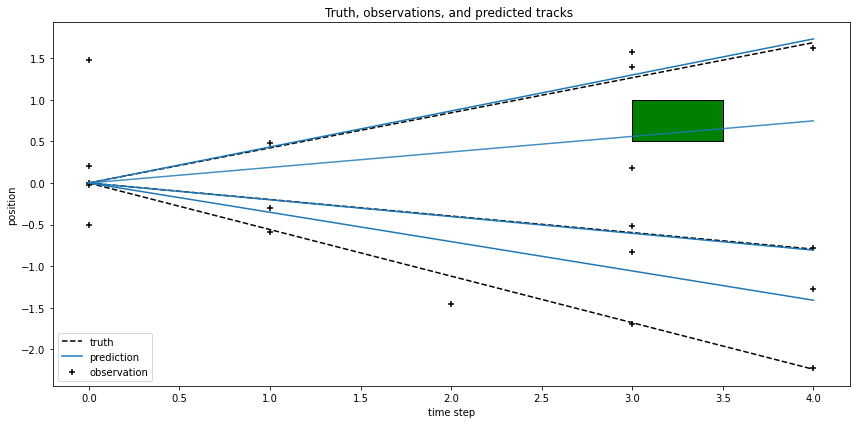

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


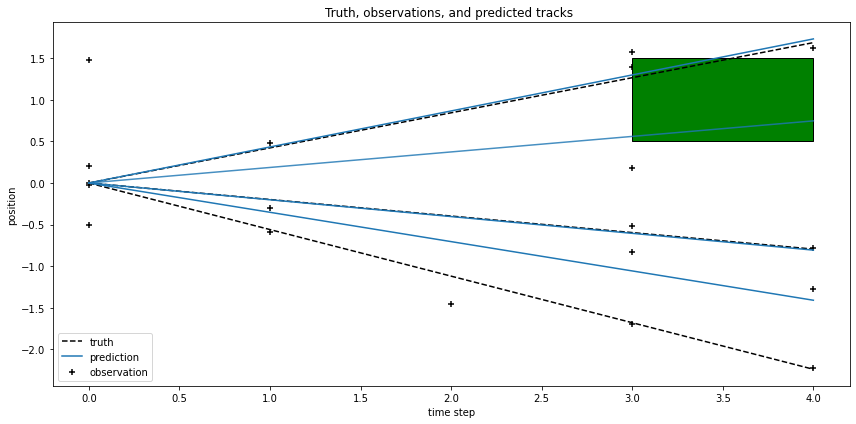

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


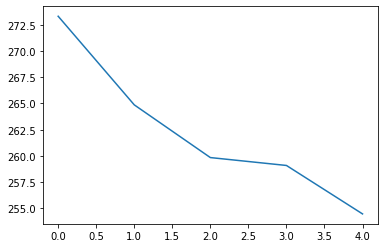

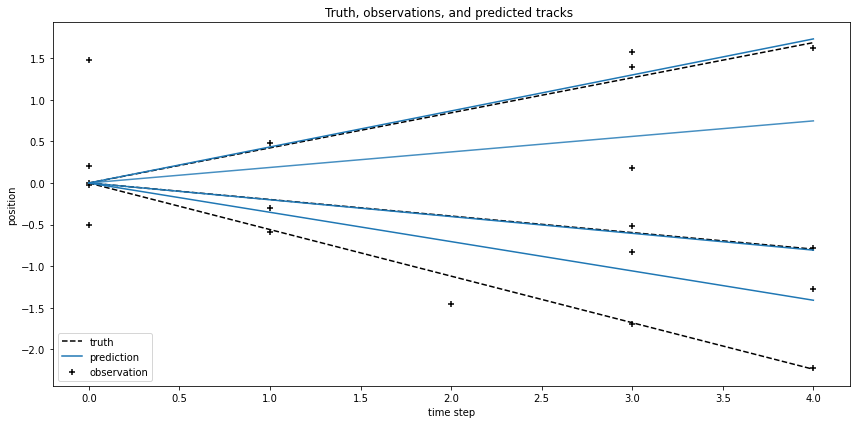

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

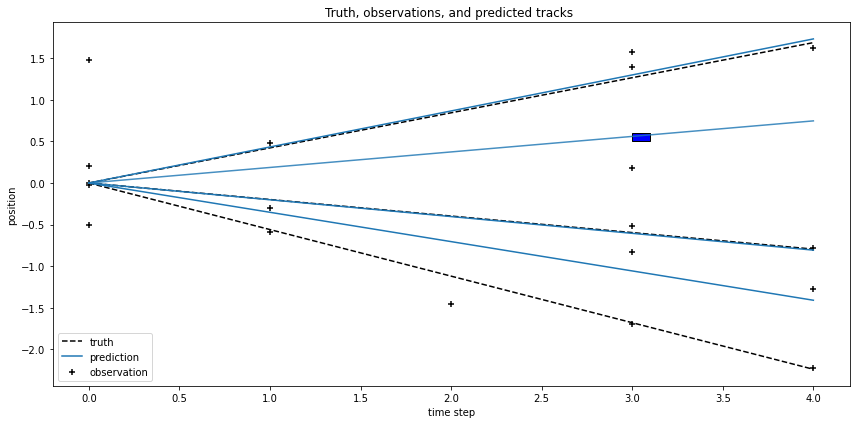

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


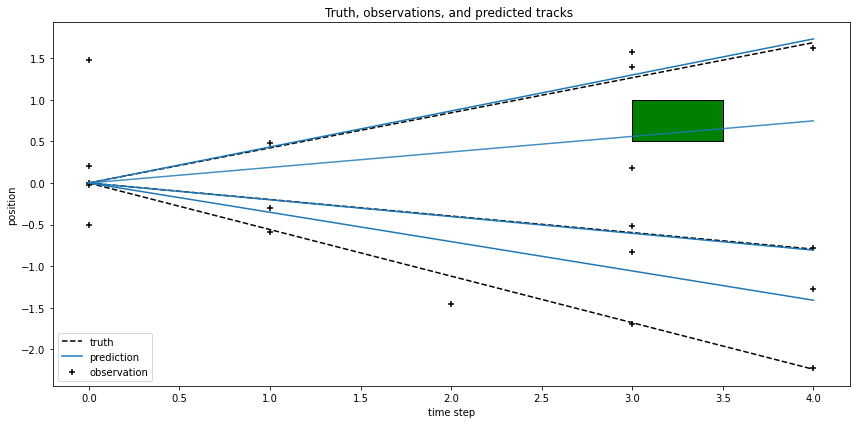

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


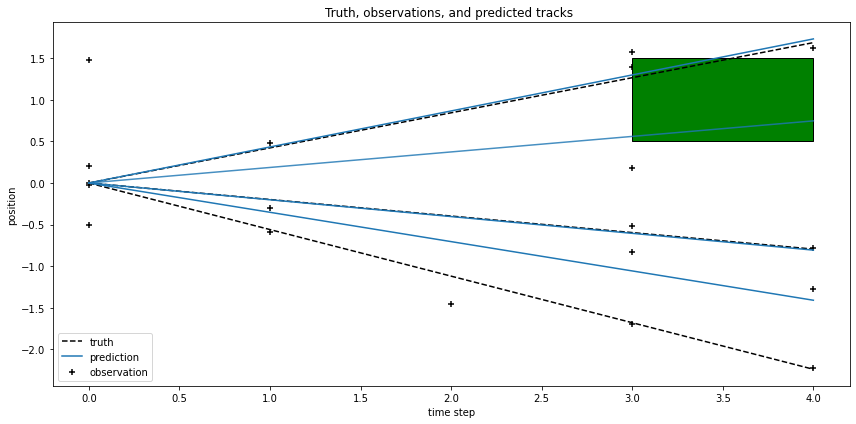

Num frames:  5  with num objects:  3
Num spurious shape:  torch.Size([5])
generated 19 detections from 3 objects
epoch    0 loss = 273.3196716308594
epoch   10 loss = 264.86669921875
epoch   20 loss = 259.8382873535156
epoch   30 loss = 259.0852355957031
epoch   40 loss = 254.46319580078125
Plotting solution with color:  yellow


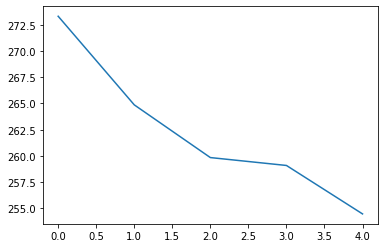

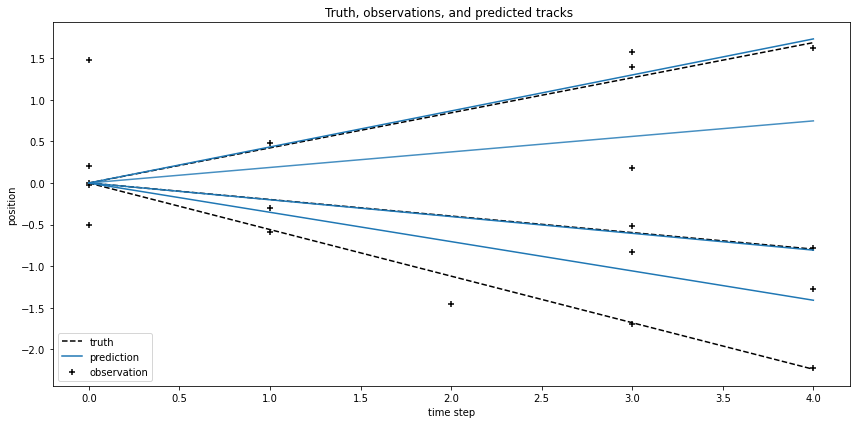

Positions!!!
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4330,  0.1867, -0.2018, -0.3525],
        [ 0.8661,  0.3733, -0.4037, -0.7050],
        [ 1.2991,  0.5600, -0.6055, -1.0575],
        [ 1.7322,  0.7467, -0.8073, -1.4099]], grad_fn=<MmBackward>)
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.6
y1:  1.7999999999999998  y2:  1.8599999999999999
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.6200000000000001
Upper left:  (3.0, 0.6)  LowerRight:  (3.1, 0.5)
Slope:  0.4
y1:  1.2000000000000002  y2:  1.2400000000000002
Found false positive wit

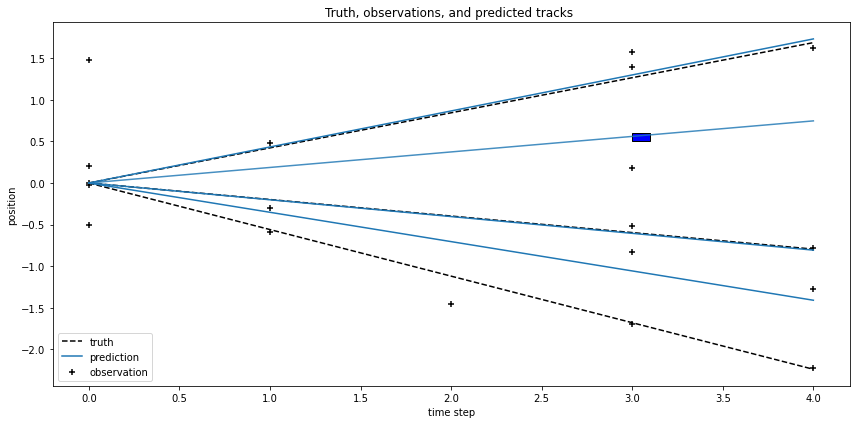

Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  prediction positions
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.0)  LowerRight:  (3.5, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.7000000000000001
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  0.5  with guess color:  green
Plotting solution with color:  green


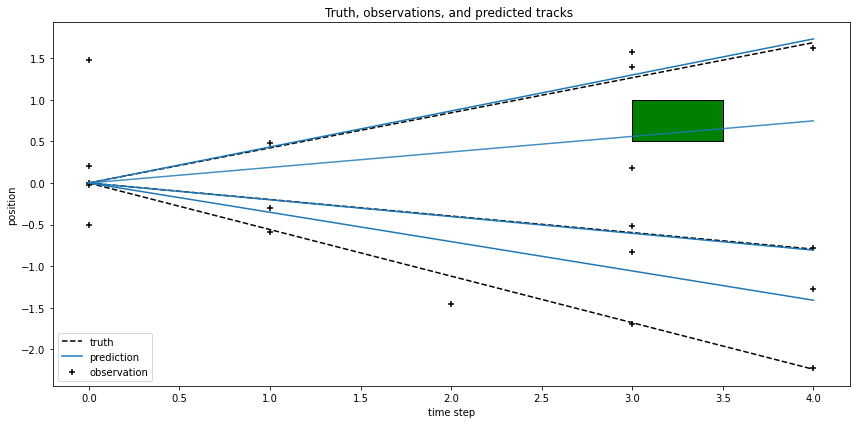

Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  prediction positions
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.0
y1:  0.0  y2:  0.0
Upper left:  (3.0, 1.5)  LowerRight:  (4.0, 0.5)
Slope:  0.2
y1:  0.6000000000000001  y2:  0.8
Returning true for:  true positions
Found true positive with:  True  and  True
Result:  GuessResult.TruePositive  for size:  1.0  with guess color:  green
Plotting solution with color:  green


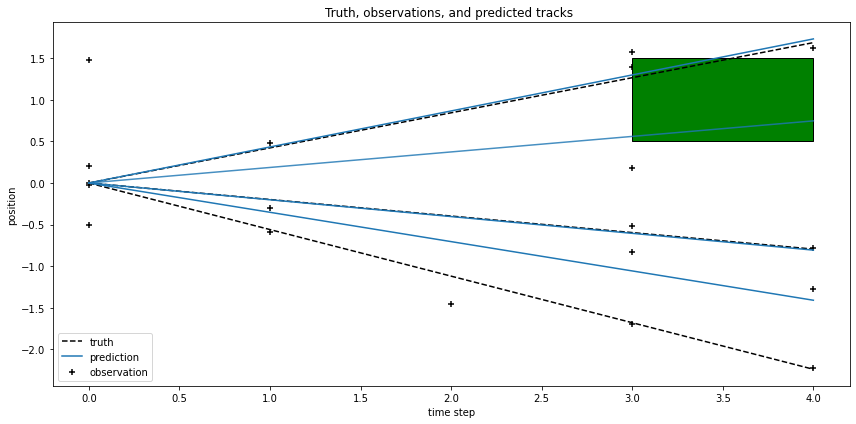

[1 3 3 1 3 3 1 3 3 1 3 3 1 3 3 1 3 3 1 3 3 1 3 3 1 3 3 1 3 3]
FP:  10  FN:  0  TP:  20  TN:  0


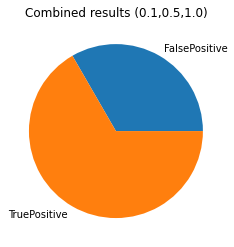

[1 1 1 1 1 1 1 1 1 1]
FP:  10  FN:  0  TP:  0  TN:  0


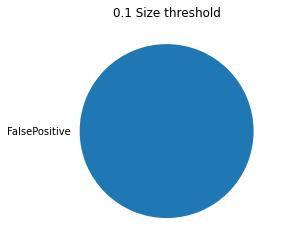

[3 3 3 3 3 3 3 3 3 3]
FP:  0  FN:  0  TP:  10  TN:  0


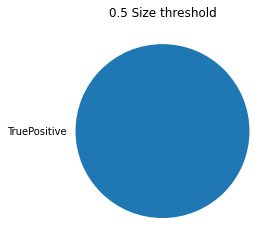

[3 3 3 3 3 3 3 3 3 3]
FP:  0  FN:  0  TP:  10  TN:  0


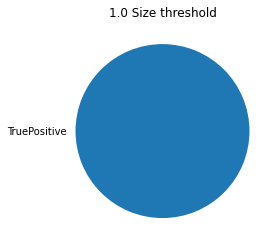

In [66]:
realScenarioManager = RealScenarioManager()
realScenarioManager.runScenario()